# C6.W1 Aggregation of yellow taxi data

Performed by Alexander Manushin 31.01.2019

## 0. Import libraries

In [1]:
import pandas as pd
from scipy.stats import binned_statistic_2d
import numpy as np
import seaborn as sns
from matplotlib import pylab as plt

In [2]:
%matplotlib inline

## 1. Read data

In [4]:
#read data of yellow taxi for may 2016
raw_data = pd.read_csv('yellow_tripdata_2016-05.csv')
raw_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


In [5]:
# data copy for working
data = raw_data.copy(deep = True)#.sample(frac = 0.001, replace = True, random_state=0) #- sample for primary testing

## 2. Data filtration

In [6]:
# function for data clearing
def data_clearer(data, zero_duration=True, zero_passenger=True, zero_distance=True, not_in_NY=True):
    lenth_before = data.shape[0]
    if zero_duration:
        before = data.shape[0]
        data.tpep_pickup_datetime = data.tpep_pickup_datetime.apply(pd.to_datetime)
        data.tpep_dropoff_datetime = data.tpep_dropoff_datetime.apply(pd.to_datetime)
        data = data[data.tpep_dropoff_datetime - data.tpep_pickup_datetime != '00:00:00']
        after = data.shape[0]
        print 'Deleted: {} items with zero duration'.format(before-after)
    if zero_passenger:
        before = data.shape[0]
        data = data[data.passenger_count != 0]
        after = data.shape[0]
        print 'Deleted: {} items with zero passengers'.format(before-after)
    if zero_distance:
        before = data.shape[0]
        data = data[data.trip_distance != 0]
        after = data.shape[0]
        print 'Deleted: {} items with zero distance'.format(before-after)
    if not_in_NY:
        before = data.shape[0]
        data = data[(data.pickup_longitude >= -74.25559) & (data.pickup_longitude <= -73.70001) &
                    (data.pickup_latitude <= 40.91553) & (data.pickup_latitude >= 40.49612)]
        after = data.shape[0]
        print 'Deleted: {} items where pickup point not in NY'.format(before-after)
    lenth_after = data.shape[0]
    print 'Left {} ({}%) items after clearing'.format(lenth_after, round(100.*lenth_after/lenth_before,2))
    return data

In [7]:
# data clearing
data = data_clearer(data)

KeyboardInterrupt: 

In [ ]:
data.head()

## 3. Data aggregation

In [8]:
regions = pd.read_csv('regions.csv', ';')
regions.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


In [9]:
bins_longitude = pd.unique(regions.west.append(regions.east))

In [10]:
bins_latitude = pd.unique(regions.south.append(regions.north))

In [11]:
%%time
ret = binned_statistic_2d(data.pickup_longitude.values, data.pickup_latitude.values, values=None, 
                          statistic='count', bins=[bins_longitude, bins_latitude], expand_binnumbers=True)

Wall time: 2.56 s


In [12]:
stats = ret.statistic

In [13]:
stats

array([[0., 0., 0., ..., 0., 8., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Text(156.5,0.5,'latitude bins')

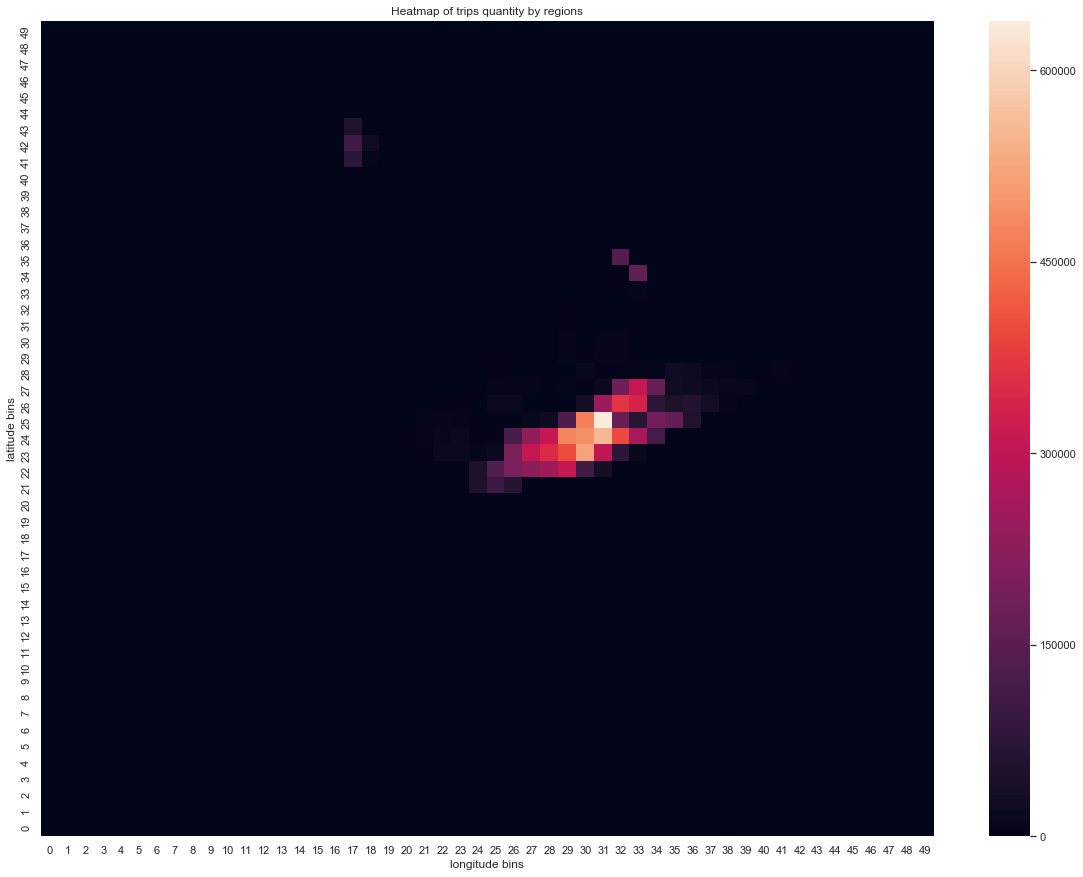

In [44]:
# visualization of trips quntity by regions
sns.set(rc={'figure.figsize':(20,15)})
sns.heatmap(pd.DataFrame(stats).sort_index(axis=0, ascending=False))
plt.title('Heatmap of trips quantity by regions')
plt.xlabel('longitude bins')
plt.ylabel('latitude bins')

In [45]:
regions_1 = pd.DataFrame(ret.binnumber, index=['longitude_n','latitude_n']).transpose()

In [46]:
# transforming binned_statistic_2d bins to regions according to  regions.csv
regions_1['region'] = (regions_1.longitude_n-1)*50 + regions_1.latitude_n

In [47]:
# checking the match of coordinates
regions_1['longitude'] = data.pickup_longitude.values
regions_1['latitude'] = data.pickup_latitude.values
regions_1.join(regions.set_index('region'), on='region').head()

,longitude_n,latitude_n,region,longitude,latitude,west,east,south,north
0,25,33,1233,-73.985901,40.768040,-73.988912,-73.977800,40.764542,40.772931
1,24,30,1180,-73.991577,40.744751,-74.000023,-73.988912,40.739378,40.747766
2,24,30,1180,-73.993073,40.741573,-74.000023,-73.988912,40.739378,40.747766
3,24,23,1173,-73.991943,40.684601,-74.000023,-73.988912,40.680660,40.689049
4,23,30,1130,-74.005280,40.740192,-74.011135,-74.000023,40.739378,40.747766


The coordinates of trip are correspond to the assigned regions

In [48]:
#adding pickup_region column in data
data['pickup_region'] = regions_1.region.values
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_region
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80,1233
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68,1180
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36,1180
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96,1173
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76,1130


In [146]:
data.sort_values('pickup_region')

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_region
7799625,1,2016-05-20 13:00:00,2016-05-20 13:59:24,1,3.10,-74.250961,40.617542,1,N,-73.994453,40.754238,1,15.00,0.0,0.5,3.16,0.00,0.3,18.96,15
8008402,2,2016-05-23 08:00:00,2016-05-23 08:55:49,5,0.33,-74.248337,40.623306,1,N,-74.244621,40.624889,2,6.00,0.0,0.5,0.00,0.00,0.3,6.80,16
1520660,2,2016-05-04 13:00:00,2016-05-04 14:06:34,1,0.93,-74.246750,40.701881,5,N,-74.262337,40.697220,2,164.00,0.0,0.5,0.00,0.00,0.3,164.80,25
11269746,1,2016-05-30 03:00:00,2016-05-30 03:49:02,1,18.10,-74.249359,40.717110,5,N,-74.249359,40.717129,1,100.00,0.0,0.0,20.05,0.00,0.3,120.35,27
6937516,1,2016-05-18 13:00:00,2016-05-18 13:44:28,1,1.50,-74.250015,40.756794,1,N,-74.250015,40.756794,2,14.50,0.0,0.5,0.00,0.00,0.3,15.30,32
6993613,1,2016-05-18 17:00:00,2016-05-18 17:08:43,1,1.00,-74.250015,40.756794,1,N,-74.250015,40.756794,1,6.50,1.0,0.5,1.25,0.00,0.3,9.55,32
6930005,1,2016-05-18 12:00:00,2016-05-18 13:15:47,1,1.20,-74.250015,40.756794,1,N,-74.250015,40.756794,2,15.00,0.0,0.5,0.00,0.00,0.3,15.80,32
7095054,1,2016-05-18 21:00:00,2016-05-18 21:54:23,1,3.80,-74.250015,40.756794,1,N,-74.250015,40.756794,1,21.00,0.5,0.5,5.57,0.00,0.3,27.87,32
7080969,1,2016-05-18 20:00:00,2016-05-18 20:58:56,1,1.00,-74.250015,40.756794,1,N,-74.250015,40.756794,1,7.00,0.5,0.5,1.66,0.00,0.3,9.96,32
7050099,1,2016-05-18 19:00:00,2016-05-18 20:06:43,1,11.20,-74.250015,40.756794,1,N,-74.250015,40.756794,1,38.00,1.0,0.5,8.44,2.44,0.3,50.68,32


In [49]:
# delete minutes and seconds from tpep_pickup_datetime column in data
data['tpep_pickup_datetime'] = data['tpep_pickup_datetime'].apply(lambda x: x.replace(second=0))
data['tpep_pickup_datetime'] = data['tpep_pickup_datetime'].apply(lambda x: x.replace(minute=0))

In [50]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_region
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80,1233
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68,1180
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36,1180
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96,1173
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76,1130


In [129]:
#aggr_data = data.groupby(['pickup_region', 'tpep_pickup_datetime']).size().reset_index(name='trips')

In [130]:
aggr_data = data.pivot_table(index='tpep_pickup_datetime', columns='pickup_region', values='VendorID', fill_value=0, aggfunc='count').unstack().to_frame().rename(columns={0:'trips'})

In [131]:
aggr_data['pickup_region'] = aggr_data.index.get_level_values(0)
aggr_data['tpep_pickup_datetime'] = aggr_data.index.get_level_values(1)

In [132]:
aggr_data.reset_index(drop=True, inplace=True)

## 4. First 5 rows of arregated spreadsheet

In [133]:
aggr_data = aggr_data[['pickup_region', 'tpep_pickup_datetime', 'trips']]

In [134]:
aggr_data.head()

,pickup_region,tpep_pickup_datetime,trips
0,15,2016-05-01 00:00:00,0
1,15,2016-05-01 01:00:00,0
2,15,2016-05-01 02:00:00,0
3,15,2016-05-01 03:00:00,0
4,15,2016-05-01 04:00:00,0


In [145]:
aggr_data.to_csv('aggr_data.csv', index=False)

## 5. Plot of trips quantity from cell that contains the Empire State Building

In [135]:
# Coordintes of Empire State Building (from Google.maps):

esb_coord = [-73.985667, 40.748444]

In [136]:
ret_esb = binned_statistic_2d([esb_coord[0]], [esb_coord[1]], values=None, 
                          statistic='count', bins=[bins_longitude, bins_latitude], expand_binnumbers=True)
region_esb = pd.DataFrame(ret_esb.binnumber, index=['longitude_n','latitude_n']).transpose()
region_esb_n = (region_esb.longitude_n-1)*50 + region_esb.latitude_n
region_esb_n = region_esb_n[0]
print 'The region that contains the Empire State Building is {}'.format(region_esb_n)

The region that contains the Empire State Building is 1231


Text(0,0.5,"Trips' quantity")

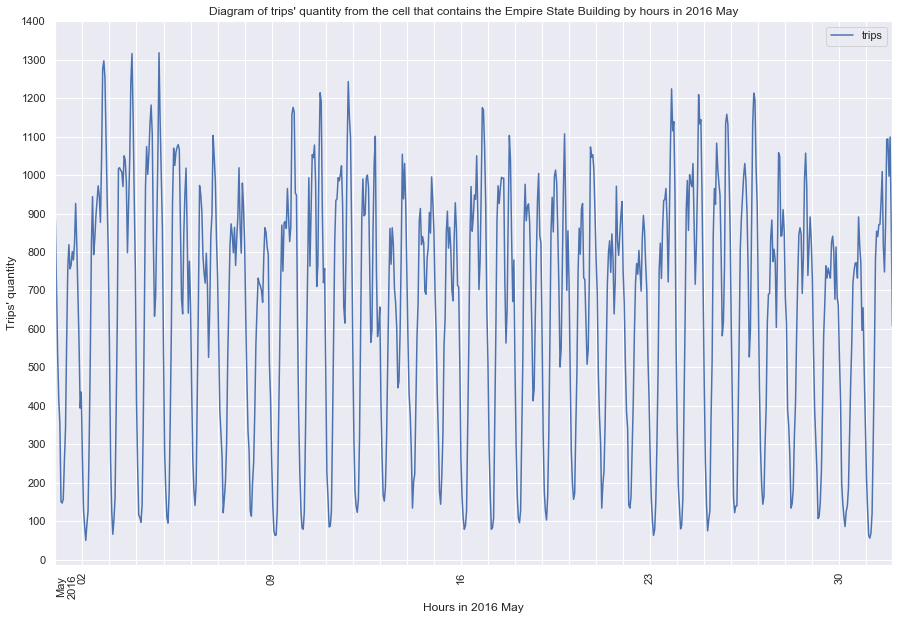

In [137]:
yticks = range(0,1500,100)
xticks = pd.date_range(aggr_data.tpep_pickup_datetime.min().date(), aggr_data.tpep_pickup_datetime.max().date(), 31)
aggr_data[aggr_data.pickup_region == region_esb_n].plot(x = 'tpep_pickup_datetime', y = 'trips', figsize=(15, 10), 
    yticks=yticks, xticks=xticks, legend=True, rot=90)
plt.title("Diagram of trips' quantity from the cell that contains the Empire State Building by hours in 2016 May")
plt.xlabel('Hours in 2016 May')
plt.ylabel("Trips' quantity")

## 6. Quantity of pairs hour-cell that has no trip in 2016 may

In [138]:
# Calculating of total pairs hour-region
total_hours = 24*31
regions_qty = regions.shape[0]
total_pairs = total_hours*regions_qty
print 'Total quantity of the pairs hour-region in 2016 may: {}'.format(total_pairs)

Total quantity of the pairs hour-region in 2016 may: 1860000


In [141]:
# Calculating of pairs hour-region that has at least one trip
pairs_has_trips = aggr_data[aggr_data.trips != 0].shape[0]
print 'Quantity of the pairs hour-region that has at least one trip in 2016 may: {}'.format(pairs_has_trips)

Quantity of the pairs hour-region that has at least one trip in 2016 may: 141762


In [142]:
# Calculating of pairs hour-region that has no trips
pairs_has_no_trips = total_pairs - pairs_has_trips
print 'Quantity of the pairs hour-region that has no trips in 2016 may: {}'.format(pairs_has_no_trips)

Quantity of the pairs hour-region that has no trips in 2016 may: 1718238
